<a href="https://colab.research.google.com/github/felkira/unifact.github.io/blob/modeling/dynamic_max_adamax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Record Each Cell's Execution Time
!pip install keras-tcn
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json, re, string, gdown, math, time
from tcn import TCN
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D, concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional
from keras.models import Model
from tensorflow.keras.preprocessing import text, sequence
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as cr, precision_recall_fscore_support as prfs
from collections import Counter
from random import randint
from google.colab import files

time: 3.43 s (started: 2022-12-12 08:59:06 +00:00)


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz

--2022-12-12 08:59:09--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  1.91MB/s    in 10m 3s  

2022-12-12 09:09:14 (1.94 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]

time: 10min 4s (started: 2022-12-12 08:59:09 +00:00)


In [ ]:
!gunzip cc.id.300.vec.gz

time: 32.2 s (started: 2022-12-12 09:09:14 +00:00)


In [ ]:
f = open('/content/cc.id.300.vec', encoding='utf-8')

embedding_vectors = {}
for row in f:
    values = row.split(' ')
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vectors[word] = weights

print(f"Size of vocabulary in FastText: {len(embedding_vectors)}")

Size of vocabulary in FastText: 2000000
time: 2min 26s (started: 2022-12-12 09:09:46 +00:00)


In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download'
gdown.download(url, 'valid-7hoaks.csv', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download
To: /content/valid-7hoaks.csv
100%|██████████| 2.07M/2.07M [00:00<00:00, 128MB/s]


'valid-7hoaks.csv'

time: 2.92 s (started: 2022-12-12 09:12:13 +00:00)


In [ ]:
main_data = pd.read_csv('/content/valid-7hoaks.csv')
pd.set_option('max_colwidth', 400)
main_data.head()

,kategori,judul,tanggal,narasi
0,Konten Yang Menyesatkan,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,26/11/2022,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,Konten Yang Salah,demo memprotes kecurangan hasil pemilihan umum di brazil pada november,25/11/2022,demo memprotes kecurangan hasil pemilihan umum brazil november
2,Konten Yang Menyesatkan,warga bogor meninggal hidup kembali,25/11/2022,warga bogor meninggal hidup
3,Konten Yang Menyesatkan,dari fauci akui vaksin tidak melindungi covid,25/11/2022,fauci akui vaksin melindungi covid
4,Konten Yang Menyesatkan,set top box dapat mendeteksi orang yang divaksin,25/11/2022,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 94.9 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
print("Shape of data (rows, cols)=>", main_data.shape)

Shape of data (rows, cols)=> (7530, 4)
time: 526 µs (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      0
dtype: int64

time: 5.86 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.describe(include='all')

,kategori,judul,tanggal,narasi
count,7530,7530,7530,7530
unique,8,7530,1317,7528
top,Valid,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,17/10/2022,foto badai petir terlihat luar angkasa
freq,2350,1,87,2


time: 22.7 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
True        2
Name: narasi, dtype: int64

time: 4.47 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.drop_duplicates(subset="narasi", keep="first", inplace=True)
main_data.reset_index(drop=True, inplace=True)
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
Name: narasi, dtype: int64

time: 14.4 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
categories = main_data.kategori.unique()
print("Categories:\n", categories)

Categories:
 ['Konten Yang Menyesatkan' 'Konten Yang Salah' 'Satire/Parodi'
 'Konten Palsu' 'Konten Yang Dimanipulasi' 'Konten Tiruan'
 'Koneksi Yang Salah' 'Valid']
time: 1.66 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.kategori.value_counts()

Valid                       2349
Konten Yang Menyesatkan     1882
Konten Yang Salah           1313
Konten Palsu                 768
Konten Yang Dimanipulasi     643
Konten Tiruan                360
Satire/Parodi                125
Koneksi Yang Salah            88
Name: kategori, dtype: int64

time: 4.04 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
main_data.loc[main_data['kategori'] == 'Konten Yang Salah', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Menyesatkan', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Dimanipulasi', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'

main_data.loc[main_data['kategori'] == 'Konten Palsu', 'kategori'] = 'Fabricated Content/Imposter Content'
main_data.loc[main_data['kategori'] == 'Konten Tiruan', 'kategori'] = 'Fabricated Content/Imposter Content'

main_data = main_data[main_data['kategori'] != 'Koneksi Yang Salah']
main_data = main_data[main_data['kategori'] != 'Satire/Parodi']

main_data.reset_index(drop=True, inplace=True)
main_data.kategori.value_counts()

Misleading Content/False Context/Manipulated Content    3838
Valid                                                   2349
Fabricated Content/Imposter Content                     1128
Name: kategori, dtype: int64

time: 13.8 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
XVal, YVal = list(main_data['narasi']), list(main_data['kategori'])

time: 1.64 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data = main_data

time: 349 µs (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data['words'] = [len(x.split()) for x in data['narasi'].tolist()]

time: 13 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data[['words','narasi']].head()

,words,narasi
0,10,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,8,demo memprotes kecurangan hasil pemilihan umum brazil november
2,4,warga bogor meninggal hidup
3,5,fauci akui vaksin melindungi covid
4,21,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 6.26 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data['words'].describe()

count    7315.000000
mean       24.798770
std        34.406444
min         2.000000
25%        10.000000
50%        18.000000
75%        27.000000
max      1139.000000
Name: words, dtype: float64

time: 8.17 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1128.0,34.176418,49.519877,3.0,9.0,17.5,41.0,951.0
Misleading Content/False Context/Manipulated Content,3838.0,22.686816,38.396630,2.0,8.0,11.0,22.0,1139.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.0,121.0


time: 41.8 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data = data[data['words']<=200]
data = data[data['words']>=3]
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,3812.0,20.960913,26.427491,3.0,8.0,11.0,22.00,196.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.00,121.0


time: 19.6 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data[data['kategori']=='Valid'] = data[data['kategori']=='Valid'][1000:2118]
data[data['kategori']=='Misleading Content/False Context/Manipulated Content'] = data[data['kategori']=='Misleading Content/False Context/Manipulated Content'][1000:2118]

data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,1118.0,24.962433,30.107245,3.0,8.0,13.0,28.00,194.0
Valid,1118.0,24.450805,7.682183,11.0,20.0,23.0,27.00,121.0


time: 32.1 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
word_freq = data['narasi'].str.split(expand=True).stack().value_counts()
word_freq = word_freq.reset_index(name='freq').rename(columns={'index': 'word'})

time: 112 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
word_freq.head(10)

,word,freq
0,indonesia,686
1,orang,486
2,tahun,366
3,negara,319
4,covid,316
5,hari,296
6,jakarta,293
7,tersebut,290
8,yosua,290
9,video,256


time: 6.74 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
print("Number of distinct words in raw data: ", len(list(word_freq['word'])))

Number of distinct words in raw data:  13513
time: 2.57 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
max_words = len(list(word_freq['word']))
# max_words = len(list(word_freq[word_freq['freq']>=2]['word']))
max_len = int(data['words'].max())

print(max_words)
print(max_len)

13513
196
time: 3 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
data = data.sample(frac=1)

time: 1.98 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
X, Y = list(data['narasi']), list(data['kategori'])

encoder = LabelEncoder()
Y = to_categorical(encoder.fit_transform(Y), dtype='uint8')

print(Y.shape)
print(encoder.classes_)

(3354, 3)
['Fabricated Content/Imposter Content'
 'Misleading Content/False Context/Manipulated Content' 'Valid']
time: 5.07 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
print(np.argmax(Y, axis=1))

[2 2 2 ... 2 2 1]
time: 1.1 ms (started: 2022-12-12 09:12:16 +00:00)


In [ ]:
def define_report(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  precision, recall, fscore, support = prfs(y_class, y_pred_class)
  report = cr(y_class, y_pred_class, target_names = encoder.classes_)
  return recall, report

def define_confusion(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  con_mat = cm(labels=y_class, predictions=y_pred_class).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
  con_mat_df = pd.DataFrame(con_mat_norm, index = encoder.classes_, columns = encoder.classes_)
  figure = plt.figure(figsize=(13, 10))
  sns.heatmap(con_mat_df, annot=True, fmt='.1%', cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def define_plot(name, param):
  plt.figure(figsize=(15, 7))
  plt.title(name)
  plt.plot(param.history[name], label='train')
  plt.plot(param.history[f'val_{name}'], label='test')
  plt.legend()
  plt.show();

time: 2.98 ms (started: 2022-12-12 09:12:17 +00:00)


# **Embedding Static Fasttext**

In [ ]:
emb_dim = 300
def define_embed(vocabSize, wordId):
  embedding_matrix = np.zeros((vocabSize, emb_dim))
  oov_count = 0
  oov_words = []
  for word, idx in wordId.items():
    if idx < vocabSize:
      embedding_vector = embedding_vectors.get(word)
      if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
      else:
        oov_count += 1 
        oov_words.append(word)
  return embedding_matrix

time: 1.08 ms (started: 2022-12-12 09:12:17 +00:00)


In [ ]:
def define_model(kernel_size, activation, optimizer, input_dim, max_length, output_dim = 300, emb_matrix = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length,
                  # Assign the embedding weight with fasttext embedding matrix
                  weights = [emb_matrix],
                  # Set the weight to be trainable (dynamic)
                  trainable = True
                  )(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(TCN(64, kernel_size=kernel_size, dilations = [1, 2], return_sequences=True, activation = activation, name = 'tcn1'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dropout(0.5)(conc)
    outp = Dense(Y.shape[1], activation="softmax")(conc)   

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

time: 2.21 ms (started: 2022-12-12 09:12:17 +00:00)


In [ ]:
model0_random = define_model(3, 'relu', 'adam', 300, 121, emb_matrix = np.random.rand(300, 300))
model0_random.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 121)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 121, 300)     90000       ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 121, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 121, 128)     227968      ['spatial_dropout1d[0][0]']  

In [ ]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=2, mode='min', restore_best_weights=True)

time: 778 µs (started: 2022-12-12 09:12:20 +00:00)


In [ ]:
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['tanh', 'relu', 'elu', 'selu', 'swish']
optimizers = ['adamax']
kernel_sizes = [2, 3, 4, 5, 6, 7, 8]

columns = ['Optimizer', 'Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'accAVG', 'loss1', 'loss2', 'loss3', 'loss4', 'loss5', 'lossAVG']
record = pd.DataFrame(columns = columns)
kfold = KFold(n_splits=5, shuffle=True)

sentences, labels = X, Y

clouds = []
valid_selected = []
false_selected = []
imposter_selected = []
models = []
recalls = []
reports = []
metas = []
exp = 0

for optimizer in optimizers:
  for activation in activations:
    for kernel_size in kernel_sizes:
      exp+=1
      print('--------------------------------------------------------------')
      print('Training {}: {} optimizer, {} activation, {} kernel size.'.format(exp, optimizer, activation, kernel_size))
      print('--------------------------------------------------------------')
      acc_list = []
      loss_list = []
      for train, test in kfold.split(sentences):

        train_x, test_x = [], []
        train_y, test_y = [], []
        
        for i in train:
          train_x.append(sentences[i])
          train_y.append(labels[i])
        for i in test:
          test_x.append(sentences[i])
          test_y.append(labels[i])

        train_valid = []
        train_false = []
        train_imposter = []
        for i in range(len(train_y)):
          label = list(encoder.inverse_transform([np.argmax(train_y[i])]))[0]
          if label == 'Valid':
            for j in train_x[i].split(): train_valid.append(j)
          if label == 'Misleading Content/False Context/Manipulated Content':
            for j in train_x[i].split(): train_false.append(j)
          if label == 'Fabricated Content/Imposter Content':
            for j in train_x[i].split(): train_imposter.append(j)
        
        valid_res = dict(Counter(train_valid))
        false_res = dict(Counter(train_false))
        imposter_res = dict(Counter(train_imposter))
        
        valid_selected.append({k: v for k, v in sorted(valid_res.items(), key=lambda item: item[1], reverse=True)})
        false_selected.append({k: v for k, v in sorted(false_res.items(), key=lambda item: item[1], reverse=True)})
        imposter_selected.append({k: v for k, v in sorted(imposter_res.items(), key=lambda item: item[1], reverse=True)})
        
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        tokenizer = text.Tokenizer(num_words = max_words, oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)
        Xtrain = sequence.pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = sequence.pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        wordIdx = tokenizer.word_index
        clouds.append(wordIdx)
        vocabSize = len(wordIdx)+1
        embedding_matrix = define_embed(vocabSize, wordIdx)

        model = define_model(kernel_size, activation, optimizer, input_dim=vocabSize, max_length=max_len, emb_matrix=embedding_matrix)
        history = model.fit(Xtrain, train_y, batch_size=50, epochs=100, verbose=0, 
                  callbacks=[callbacks], validation_data=(Xtest, test_y))
        
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print(f'Loss: {loss} - Accuracy: {acc}\n')
        result = model.predict(Xtest)
        recall, report = define_report(result, test_y)
        metas.append([Xtest, test_y, result, history])
        reports.append(report)
        recalls.append(recall)
        acc_list.append(acc*100)
        loss_list.append(loss)
        models.append(model)
          
      mean_acc = np.array(acc_list).mean()
      mean_loss = np.array(loss_list).mean()
      parameters = [optimizer, activation, kernel_size]
      entries = parameters + acc_list + [mean_acc] + loss_list + [mean_loss]
      temp = pd.DataFrame([entries], columns=columns)
      record = record.append(temp, ignore_index=True)
      print('\n')

In [ ]:
record

,Optimizer,Activation,Filters,acc1,acc2,acc3,acc4,acc5,accAVG,loss1,loss2,loss3,loss4,loss5,lossAVG
0,adamax,tanh,2,87.630403,85.842025,84.649777,84.649777,85.373133,85.629023,0.306095,0.380529,0.385224,0.370197,0.377000,0.363809
1,adamax,tanh,3,87.481374,83.010435,87.332338,85.543966,85.074627,85.688548,0.335522,0.414521,0.328523,0.360601,0.371083,0.362050
2,adamax,tanh,4,88.524592,86.140090,84.500748,86.438149,87.462687,86.613253,0.331285,0.361970,0.374571,0.343751,0.335903,0.349496
3,adamax,tanh,5,84.351712,86.140090,83.010435,87.928462,86.567163,85.599573,0.382800,0.376494,0.393634,0.293436,0.336806,0.356634
4,adamax,tanh,6,84.947836,84.947836,85.842025,85.842025,84.328359,85.181617,0.368226,0.358930,0.329702,0.367048,0.371980,0.359177
5,adamax,tanh,7,87.481374,86.140090,87.481374,85.842025,87.164181,86.821809,0.362784,0.348268,0.344468,0.344601,0.333953,0.346815
6,adamax,tanh,8,86.289120,89.269745,85.842025,87.928462,85.522389,86.970348,0.348366,0.309741,0.346360,0.338553,0.356639,0.339932
7,adamax,relu,2,85.991061,81.967211,85.842025,86.587185,84.029853,84.883467,0.362906,0.435213,0.373311,0.344647,0.390472,0.381310
8,adamax,relu,3,85.245901,86.289120,83.010435,87.779433,83.731341,85.211246,0.362162,0.342565,0.413954,0.342377,0.397376,0.371687
9,adamax,relu,4,89.269745,86.140090,83.308494,86.289120,83.880597,85.777609,0.281724,0.333721,0.449641,0.340565,0.372174,0.355565


time: 23 ms (started: 2022-12-12 09:57:02 +00:00)


In [ ]:
record[['Activation', 'accAVG']].groupby(by='Activation').max().sort_values(by='accAVG', ascending=False)

,accAVG
Activation,
tanh,86.970348
elu,86.792134
relu,86.553417
swish,86.225905
selu,86.136041


time: 17.9 ms (started: 2022-12-12 09:57:03 +00:00)


In [ ]:
record[['Activation', 'lossAVG']].groupby(by='Activation').min().sort_values(by='lossAVG', ascending=True)

,lossAVG
Activation,
tanh,0.339932
elu,0.346098
selu,0.349710
relu,0.349761
swish,0.365220


time: 7.72 ms (started: 2022-12-12 09:57:03 +00:00)


In [ ]:
max_recall_0 = [i[0] for i in recalls]
max_recall_0_idx = [i for i in range(len(max_recall_0)) if max_recall_0[i] >= .81]
print(*max_recall_0_idx, sep=', ')

1, 5, 7, 10, 11, 18, 19, 22, 24, 29, 31, 32, 33, 38, 45, 53, 55, 60, 76, 77, 78, 87, 106, 112, 117, 128, 129, 130, 134, 150, 165
time: 8.94 ms (started: 2022-12-12 09:58:56 +00:00)


In [ ]:
recall_filtered = [m for m in [[i, rec[1]] for i, rec in enumerate(recalls) if i in max_recall_0_idx] if m[1] >= .81]

print(recall_filtered)

[[1, 0.8269230769230769], [7, 0.8405797101449275], [10, 0.8592964824120602], [18, 0.8475336322869955], [19, 0.8229665071770335], [29, 0.8317757009345794], [31, 0.8951965065502183], [33, 0.868421052631579], [45, 0.8583690987124464], [55, 0.84251968503937], [60, 0.8866995073891626], [78, 0.8638297872340426], [87, 0.817258883248731], [106, 0.8853211009174312], [117, 0.8755364806866953], [134, 0.8167330677290837], [165, 0.8508771929824561]]
time: 1.02 ms (started: 2022-12-12 09:58:57 +00:00)


In [ ]:
for i in range(len(recall_filtered)):
  print(reports[recall_filtered[i][0]], '\n\n')

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.87      0.82      0.84       246
Misleading Content/False Context/Manipulated Content       0.77      0.83      0.80       208
                                               Valid       0.93      0.94      0.93       217

                                            accuracy                           0.86       671
                                           macro avg       0.86      0.86      0.86       671
                                        weighted avg       0.86      0.86      0.86       671
 


                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.85      0.81      0.83       223
Misleading Content/False Context/Manipulated Content       0.81      0.84      0.82       207
                                               Valid 

In [ ]:
bests = [i for i in range(len(recall_filtered))]
selecteds = [recall_filtered[i][0] for i in bests]

time: 790 µs (started: 2022-12-12 10:10:40 +00:00)


In [ ]:
def tokenize(text, cloud):
  s = text.split()
  return [cloud[s[i]] if s[i] in cloud else 1 for i in range(len(s))]

def pad_sequence(seq):
  return [0 if i < (max_len - len(seq)) else seq[i - (max_len - len(seq))] for i in range(max_len)]

time: 1.47 ms (started: 2022-12-12 10:10:41 +00:00)


In [ ]:
results = []

for j in selecteds:
  predict_temp = []
  false_temp = []
  print(f'model-{j} predict')
  for i in range(len(XVal)):
    seq = tokenize(XVal[i], clouds[j])
    padded = np.array([pad_sequence(seq)])
    preds = models[j].predict(padded)
    proba = preds[0].tolist()
    classes = list(encoder.classes_)
    prediction = classes[proba.index(max(preds[0]))]
    if prediction == YVal[i]: predict_temp.append(True)
    else: false_temp.append(classes.index(YVal[i]))

  results.append(f'correct: {len(predict_temp)}/{len(XVal)}: {round(len(predict_temp)/len(XVal) * 100, 3)}%  -  false-i: {false_temp.count(0)}  -  false-m: {false_temp.count(1)}  -  false-v: {false_temp.count(2)}')

In [ ]:
for i in range(len(selecteds)):
  print('model:', selecteds[i], f'\n{results[i]}')

model: 1 
correct: 6265/7315: 85.646%  -  false-i: 147  -  false-m: 793  -  false-v: 110
model: 7 
correct: 6397/7315: 87.45%  -  false-i: 187  -  false-m: 654  -  false-v: 77
model: 10 
correct: 6203/7315: 84.798%  -  false-i: 188  -  false-m: 867  -  false-v: 57
model: 18 
correct: 6236/7315: 85.249%  -  false-i: 155  -  false-m: 829  -  false-v: 95
model: 19 
correct: 6010/7315: 82.16%  -  false-i: 133  -  false-m: 1053  -  false-v: 119
model: 29 
correct: 6280/7315: 85.851%  -  false-i: 221  -  false-m: 706  -  false-v: 108
model: 31 
correct: 6310/7315: 86.261%  -  false-i: 203  -  false-m: 699  -  false-v: 103
model: 33 
correct: 6245/7315: 85.373%  -  false-i: 193  -  false-m: 765  -  false-v: 112
model: 45 
correct: 6118/7315: 83.636%  -  false-i: 180  -  false-m: 987  -  false-v: 30
model: 55 
correct: 6286/7315: 85.933%  -  false-i: 208  -  false-m: 748  -  false-v: 73
model: 60 
correct: 6044/7315: 82.625%  -  false-i: 222  -  false-m: 991  -  false-v: 58
model: 78 
correct:

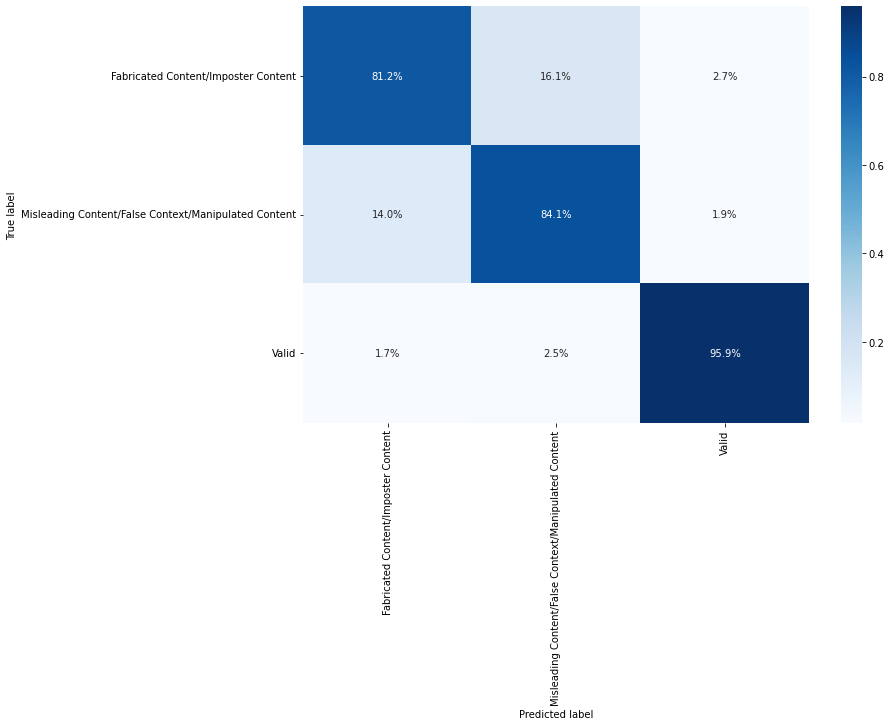

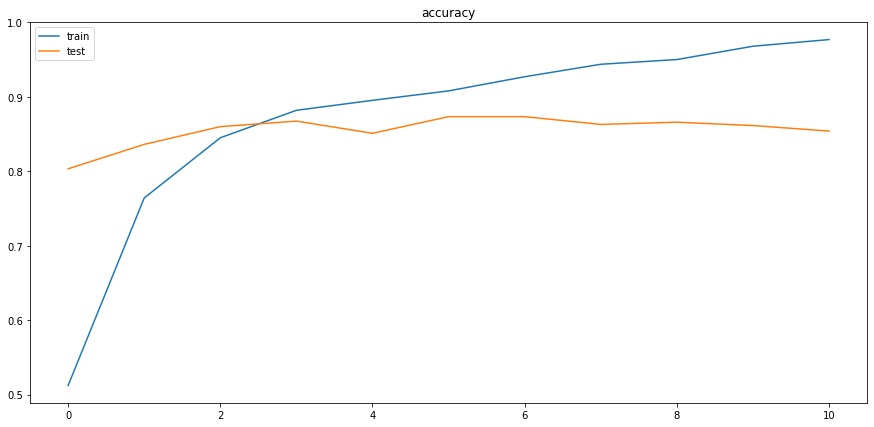

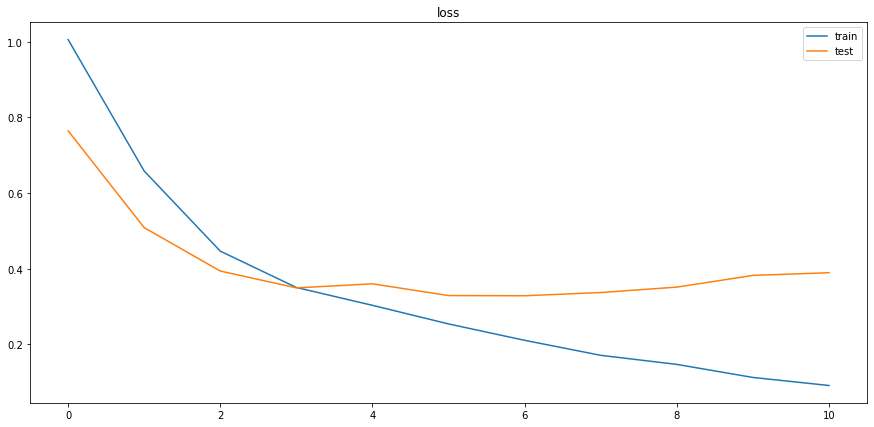




time: 695 ms (started: 2022-12-12 12:13:43 +00:00)


In [ ]:
best = [7, 6397]
define_confusion(metas[best[0]][2], metas[best[0]][1])
print('\n')
define_plot('accuracy', metas[best[0]][3])
print('\n')
define_plot('loss', metas[best[0]][3])
print('\n\n')

In [ ]:
record.to_excel('acc_loss_records.xlsx', index=False, encoding='utf-8')

time: 263 ms (started: 2022-12-12 12:13:43 +00:00)


In [ ]:
def cr_to_excel(report, index, score):
    report_data = []
    lines = report.split('\n')
    for line in (lines[2:5]+lines[7:9]):
        row = {}
        row_data = line.split()
        row['class'] = ' '.join(row_data[0:-4])
        row['precision'] = row_data[-4]
        row['recall'] = row_data[-3]
        row['f1_score'] = row_data[-2]
        row['support'] = row_data[-1]
        row['accuracy'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'acc{(index%5) + 1}'], 2)
        row['loss'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'loss{(index%5) + 1}'], 4)
        row['activation'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Activation']
        row['optimizer'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Optimizer']
        row['kernel'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Filters']
        row['test_score'] = round(((score-3354)/(7315-3354)*100), 2)
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_excel(f'classification_report-{index}.xlsx', index = False)

cr_to_excel(reports[best[0]], best[0], best[1])

time: 19.8 ms (started: 2022-12-12 12:13:44 +00:00)


In [ ]:
def clouds_to_json(index):
  with open(f'word_dict-{index}.json' , 'w') as file:    
    json.dump(clouds[index], file)

clouds_to_json(best[0])

time: 15.4 ms (started: 2022-12-12 12:13:44 +00:00)


In [ ]:
def res_to_json(index):
  with open(f'residu-{index}.json' , 'w') as file:    
    json.dump({'valid': valid_selected[index], 'false': false_selected[index], 'imposter': imposter_selected[index]}, file)

res_to_json(best[0])

time: 23.4 ms (started: 2022-12-12 12:13:44 +00:00)


In [ ]:
models[best[0]].save(f"model-{best[0]}.h5")

time: 173 ms (started: 2022-12-12 12:13:44 +00:00)


In [ ]:
files.download('acc_loss_records.xlsx')

files.download(f'classification_report-{best[0]}.xlsx')
files.download(f'word_dict-{best[0]}.json')
files.download(f'residu-{best[0]}.json')
files.download(f'model-{best[0]}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 26.9 ms (started: 2022-12-12 12:13:44 +00:00)
